## Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from re import search
import matplotlib.pyplot as plt
from mlp_helper import mlp_train
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn import preprocessing
import torch.fft as fft
import scipy.signal as signal
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


## Helper functions

In [2]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    dataframe = pd.read_csv(file_path)

    # Convert DataFrame to a tensor
    tensor = torch.tensor(dataframe.values)

    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):#, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                name_variableR = i+'_'+j+'_'+label[index_k]
                # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # pd.set_option('display.max_rows', None)
            # print(label_df)
            # print(main_df.iloc[1067:1228])
            # pd.set_option('display.max_rows', 10)
            # print(f'main df:\n{main_df}')

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,1,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            # print(main_df)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])
    
# Custom dataset class
class MyDataset2(Dataset):
    def __init__(self, sequence,labels, time_steps):
        self.sequence = sequence
        self.labels = labels
        self.time_steps = time_steps

    def __len__(self):
        return len(self.labels) - self.time_steps + 1

    def __getitem__(self, idx):
        sequence = self.sequence[idx:idx+self.time_steps]
        label = self.labels[idx+int((self.time_steps)/2)]
        return sequence, label

# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]


## Data reading / importing

In [3]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,0]
labelssteps = tensor_unified[:,7]
labels = labels.long()
labelssteps = labelssteps.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [10]:
# Convert the PyTorch tensor to a NumPy array
numpy_array = labelssteps.numpy()

# Reshape the NumPy array to a single column
reshaped_array = numpy_array.reshape(-1, 1)

# Create a pandas DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array, columns=['Column_Name'])

labels_df_g = df.loc[0:2000]
print(labels_df_g)


      Column_Name
0               0
1               0
2               0
3               0
4               0
...           ...
1996            0
1997            0
1998            0
1999            0
2000            0

[2001 rows x 1 columns]


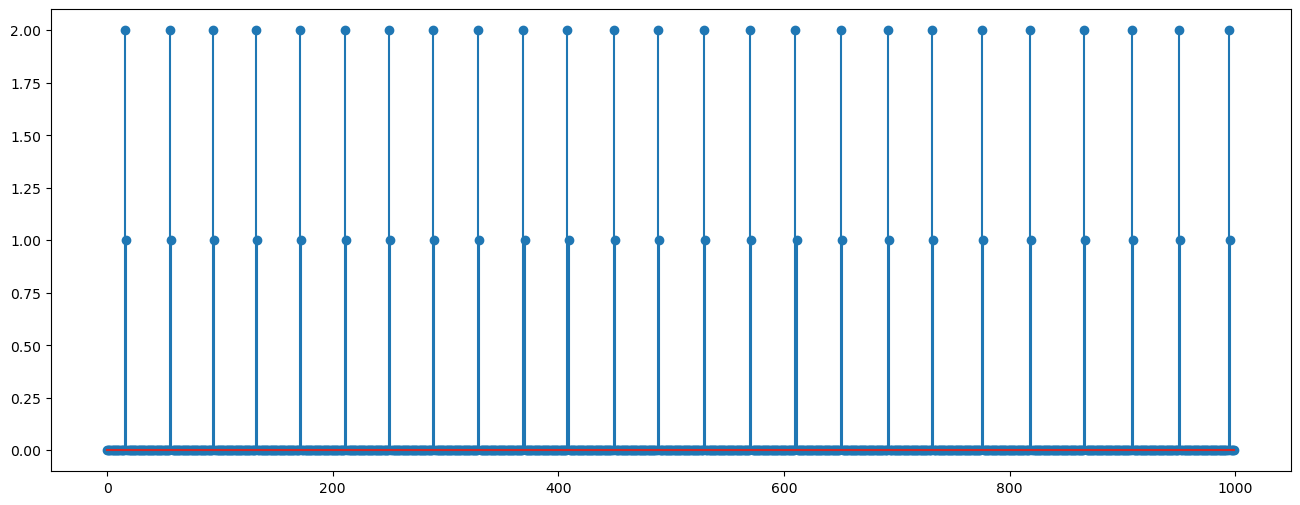

In [11]:
# data_df_g.head
labelssteps2 = labelssteps[5000:6000]
fig, (ax) = plt.subplots(1,figsize = (16,6))

# Assuming your columns are named 'col1', 'col2', ..., 'col6'

ax.stem(labelssteps2, label='Activity')


plt.show()


In [54]:
scaler = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scaler.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDatasetLSTM(training_data_scaled,time_steps=40)
train_data_scaled, test_data_scaled = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


## Graphing

In [13]:
labels_df = pd.DataFrame(training_data[1].numpy())
data_df = pd.DataFrame(data_scaled.numpy())

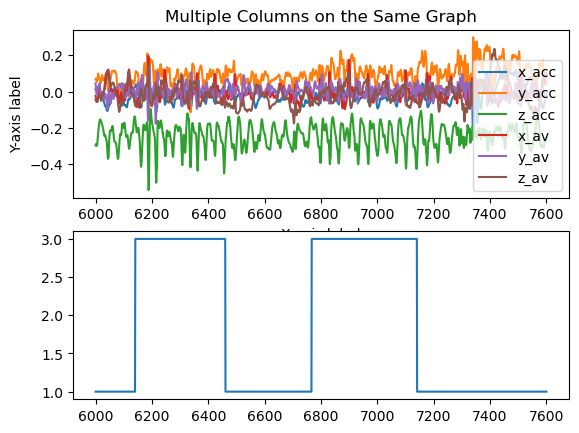

In [14]:

# print(data_df)
size_w = 1600
a_begin = 6000
aend = a_begin+size_w
data_df_g = data_df.loc[a_begin:aend]
labels_df_g = labels_df.loc[a_begin:aend]

# Assuming you have a DataFrame named 'df' and a list of new column names
new_column_names = ['x_acc', 'y_acc', 'z_acc', 'x_av', 'y_av', 'z_av']
new_column_names_labels = ['activity']

# Assign the new column names to the DataFrame
data_df_g.columns = new_column_names
labels_df_g.columns = new_column_names_labels
# data_df_g.head

fig, (ax,ax1) = plt.subplots(2,1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(data_df_g['x_acc'], label='x_acc')
ax.plot(data_df_g['y_acc'], label='y_acc')
ax.plot(data_df_g['z_acc'], label='z_acc')
ax.plot(data_df_g['x_av'], label='x_av')
ax.plot(data_df_g['y_av'], label='y_av')
ax.plot(data_df_g['z_av'], label='z_av')

ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Multiple Columns on the Same Graph')
ax.legend()

ax1.plot(labels_df_g['activity'], label='Activity')

plt.show()


## MLP

1 Iteration - Loss:  {1.107177452112461}


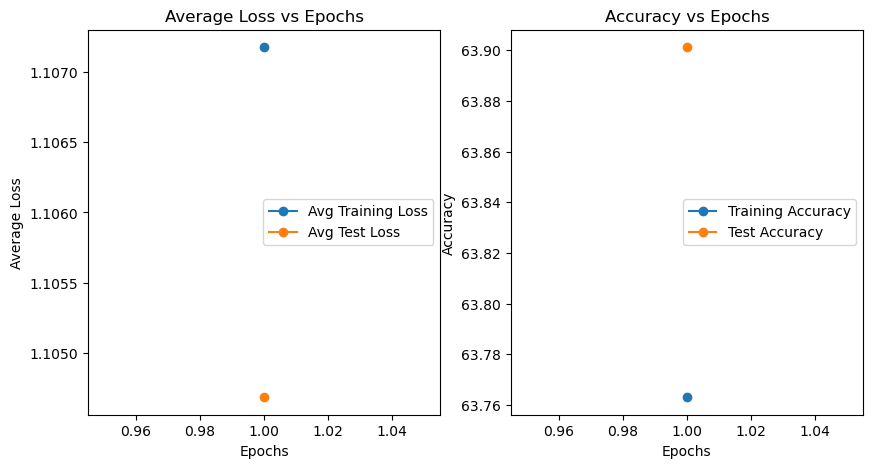

In [56]:
epochs = 1
b_size = 10
hidden_dims = [100,50,10]
lr = 0.005

model,losses,plot = mlp_train(train_data,hidden_dims,epochs,b_size,lr,False,True,feature_dim,class_dim,test_data)

## LSTM for Activity detection

In [67]:
# Example usage
batch_size = 64

dataloader = DataLoader(train_data_scaled, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled, batch_size=batch_size, shuffle=False,drop_last= True)

class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        #out = self.fc(hn.squeeze(0))
        # print(f'out is now {out.shape}')
        out = out[:, -1, :]
        # print(f'out is now 2 {out.shape}')
        out = self.fc(out)
        # print(f'out is now 3 {out.shape}')
        #out = self.sfm(out)
        # out = torch.argmax(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

print('Preparing datasets')

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

lr = 0.01
n_epochs = 15
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')
# print('dataloader', dataloader)
# sequence_length = 10

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch_v.size(0)
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


Preparing datasets
Start model training
Accuracy epoch 1 90.39%
Epoch 1 best model saved with accuracy: 90.39%
Accuracy epoch 2 93.42%
Epoch 2 best model saved with accuracy: 93.42%
Accuracy epoch 3 63.87%
Accuracy epoch 4 63.71%
Accuracy epoch 5 63.95%
Epoch:   5. Loss: 1.1587. Acc.: 63.95%
Accuracy epoch 6 63.94%
Accuracy epoch 7 63.30%
Early stopping on epoch 7


## LSTM for Step prediction with Activity

#### Step size 40

In [11]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [12]:
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=40)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [103]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [105]:
dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

lr = 0.01
n_epochs = 15
best_acc = 0
patience, trials = 8, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Accuracy epoch 1 96.82%
Epoch 1 best model saved with accuracy: 96.82%
Accuracy epoch 2 97.06%
Epoch 2 best model saved with accuracy: 97.06%
Accuracy epoch 3 97.08%
Epoch 3 best model saved with accuracy: 97.08%
Accuracy epoch 4 96.45%
Accuracy epoch 5 96.44%
Epoch:   5. Loss: 0.1842. Acc.: 96.44%
Accuracy epoch 6 96.45%
Accuracy epoch 7 96.45%
Accuracy epoch 8 96.45%
Accuracy epoch 9 96.40%
Accuracy epoch 10 96.45%
Epoch:  10. Loss: 0.1622. Acc.: 96.45%
Accuracy epoch 11 96.45%
Early stopping on epoch 11


#### Step size 40 with Activity and cleaning Signal

In [19]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [20]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns


scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

training_data_scaled = [data_scaled2,labels]


feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled2.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=40)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [6]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [8]:
batch_size = 128

dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 8
hidden_dim = 120
layer_dim = 1
output_dim = 3

lr = 0.001
n_epochs = 20
best_acc = 0
patience, trials = 10, 0

print_n_batch = 5
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)


model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    # print(f'Accuracy epoch {epoch} {acc:2.3%}')

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_lstm_better_data.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   1. Loss: 0.1282. Acc.: 96.438%
Epoch 1 best model saved with accuracy: 96.44%
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   2. Loss: 0.1190. Acc.: 96.442%
Epoch 2 best model saved with accuracy: 96.44%
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   3. Loss: 0.1163. Acc.: 96.442%
Epoch 3 best model saved with accuracy: 96.44%
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   4. Loss: 0.1044. Acc.: 96.441%
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   5. Loss: 0.1116. Acc.: 96.488%
Epoch 5 best model saved with accuracy: 96.49%
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   6. Lo

#### LSTM with 2 layers, dropout. Only Accelaration

In [51]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [52]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns
data_norm_new = data_norm_new[:,[1,2,3,7]]


scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

training_data_scaled = [data_scaled2,labels]


feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled2.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset2(data_scaled2,labels,time_steps=25)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [53]:
class LSTMClassifier_steps_dropout(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2,int_dim = 128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [54]:
path_steps_model = 'lstm_batchnorm_middle_value.pth'
batch_size = 128

dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 4
hidden_dim = 120
layer_dim = 2
output_dim = 3

lr = 0.001
n_epochs = 30
best_acc = 0.97271
best_rec = 0.72009
patience, trials = 10, 0

print_n_batch = 3
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)

model = LSTMClassifier_steps_dropout(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        # print(f'y_batch {y_batch.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    prec,rec = [],[]
    with torch.no_grad():
        for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
            out = model(x_batch_v)
            probs = F.log_softmax(out, dim=1)
            preds = probs.argmax(dim=1)

            # Convert tensors to NumPy arrays
            y_true = y_batch_v.numpy()
            y_pred = preds.numpy()

            # Calculate precision and recall for each class
            precision = precision_score(y_true, y_pred, average=None,zero_division=1)
            recall = recall_score(y_true, y_pred, average=None,zero_division=1)

            # Calculate average precision and recall
            avg_precision = np.mean(precision)
            avg_recall = np.mean(recall)
            prec.append(avg_precision)
            rec.append(avg_recall)

            total += (y_batch_v.size(0))
            correct += (preds == y_batch_v).sum().item()

    avg_rec = sum(rec) / len(rec)
    avg_prec = sum(prec) / len(prec)
    # print(f'recall {avg_rec} precision {avg_prec}')
    acc = correct / total
    # print(f'Accuracy epoch {epoch} {acc:2.3%}')
    condition1 = avg_rec > best_rec
    condition2 = acc > best_acc


    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%} Recall: {avg_rec:2.3%} Prec.: {avg_precision:2.3%}')
    
    if condition1:
        trials = 0
        best_rec = avg_rec
        torch.save(model.state_dict(), 'lstm_batchnorm_middle_value_best_recall2.pth')
        print(f'Epoch {epoch} best model saved with recall: {best_rec:2.3%}')

    if condition2:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'lstm_batchnorm_middle_value2.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.3%}')

    if not condition1 and not condition2:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   1. Loss: 0.0892. Acc.: 97.278% Recall: 70.484% Prec.: 90.027%
Epoch 1 best model saved with accuracy: 97.278%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   2. Loss: 0.0620. Acc.: 97.306% Recall: 70.986% Prec.: 98.374%
Epoch 2 best model saved with accuracy: 97.306%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   3. Loss: 0.0703. Acc.: 97.410% Recall: 71.268% Prec.: 97.984%
Epoch 3 best model saved with accuracy: 97.410%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   4. Loss: 0.0131. Acc.: 97.256% Recall: 70.216% Prec.: 98.374%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   5. Loss: 0.0457. Acc.: 97.441% Recall: 70.928% Prec.: 98.770%
Epoch 5 best model saved with accuracy: 97.441%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   6. Loss: 0.0746. Acc.: 97.457% Recall: 72.615% Prec.: 99.174%
Epoch 6 best model saved with recall: 72.615%
Epoch 6 best m

#### LSTM with 2 layers, dropout. With Gyroscope

In [10]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [11]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns
data_norm_new = data_norm_new[:,[1,2,3,7]]


scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

training_data_scaled = [data_scaled2,labels]


feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled2.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset2(data_scaled2,labels,time_steps=25)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [14]:
class LSTMClassifier_steps_dropout(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2,int_dim = 100):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [16]:
model_path = 'lstm_batchnorm_middle_value_best_gyro.pth'
batch_size = 128

dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 4
hidden_dim = 128
layer_dim = 2
output_dim = 3

lr = 0.0001
n_epochs = 40
best_acc = 0.9723
best_rec = 0.7414
best_score = 0.8433
patience, trials = 25, 0

print_n_batch = 3
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)

model = LSTMClassifier_steps_dropout(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        # print(f'y_batch {y_batch.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    prec,rec = [],[]
    with torch.no_grad():
        for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
            out = model(x_batch_v)
            probs = F.log_softmax(out, dim=1)
            preds = probs.argmax(dim=1)

            # Convert tensors to NumPy arrays
            y_true = y_batch_v.numpy()
            y_pred = preds.numpy()

            # Calculate precision and recall for each class
            precision = precision_score(y_true, y_pred, average=None,zero_division=1)
            recall = recall_score(y_true, y_pred, average=None,zero_division=1)

            # Calculate average precision and recall
            avg_precision = np.mean(precision)
            avg_recall = np.mean(recall)
            prec.append(avg_precision)
            rec.append(avg_recall)

            total += (y_batch_v.size(0))
            correct += (preds == y_batch_v).sum().item()

    avg_rec = sum(rec) / len(rec)
    avg_prec = sum(prec) / len(prec)
    # print(f'recall {avg_rec} precision {avg_prec}')
    acc = correct / total
    score = (avg_rec+avg_prec+acc)/3
    # print(f'Accuracy epoch {epoch} {acc:2.3%}')
    condition1 = avg_rec > best_rec
    condition2 = acc > best_acc
    condition3 = score > best_score


    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%} Recall: {avg_rec:2.3%} Prec.: {avg_prec:2.3%} Score: {score:2.3%}')
    
    if condition1:
        trials = 0
        best_rec = avg_rec
        torch.save(model.state_dict(), 'lstm_batchnorm_middle_value_best_recall_gyro.pth')
        print(f'Epoch {epoch} best model saved with recall: {best_rec:2.3%}')

    if condition2:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'lstm_batchnorm_middle_value_best_acc_gyro.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.3%}')

    if condition3:
        trials = 0
        best_score = score
        torch.save(model.state_dict(), 'lstm_batchnorm_middle_value_best_gyro.pth')
        print(f'Epoch {epoch} best model saved with score: {best_score:2.3%}')

    if not condition1 and not condition2 and not condition3:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   1. Loss: 0.0951. Acc.: 97.333% Recall: 73.065% Prec.: 83.882% Score: 84.760%
Epoch 1 best model saved with accuracy: 97.333%
Epoch 1 best model saved with score: 84.760%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   2. Loss: 0.0604. Acc.: 97.322% Recall: 74.113% Prec.: 83.241% Score: 84.892%
Epoch 2 best model saved with score: 84.892%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   3. Loss: 0.0295. Acc.: 97.348% Recall: 74.285% Prec.: 83.465% Score: 85.032%
Epoch 3 best model saved with recall: 74.285%
Epoch 3 best model saved with accuracy: 97.348%
Epoch 3 best model saved with score: 85.032%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   4. Loss: 0.0691. Acc.: 97.347% Recall: 74.634% Prec.: 83.284% Score: 85.088%
Epoch 4 best model saved with recall: 74.634%
Epoch 4 best model saved with score: 85.088%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   5. L

#### Step size 30

In [45]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [39]:
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)
ts= 40
feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=ts)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [56]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0,int_dim = 64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [47]:
batch_size = 64
dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 7
hidden_dim = 120
layer_dim = 2
output_dim = 2

lr = 0.01
n_epochs = 12
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2)
criterion = nn.CrossEntropyLoss()
# opt = torch.optim.RMSprop(model.parameters(), lr=lr)
opt = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay=0.1,weight_decay=0.1)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm_st_30_adam.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Accuracy epoch 1 96.44%
Epoch 1 best model saved with accuracy: 96.44%
Accuracy epoch 2 96.44%
Accuracy epoch 3 96.44%
Accuracy epoch 4 96.44%
Accuracy epoch 5 96.44%
Epoch:   5. Loss: 0.4522. Acc.: 96.44%
Accuracy epoch 6 96.44%
Early stopping on epoch 6


## LSTM for Step prediction without Activity

In [15]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [18]:
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)
ts = 40 # Time-steps

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=30)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [49]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [22]:
batch_size = 64

dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 6
hidden_dim = 130
layer_dim = 1
output_dim = 3

lr = 0.01
n_epochs = 20
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay=0.001)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm_wo_activity.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Accuracy epoch 1 96.45%
Epoch 1 best model saved with accuracy: 96.45%
Accuracy epoch 2 96.45%
Epoch 2 best model saved with accuracy: 96.45%
Accuracy epoch 3 96.45%
Epoch 3 best model saved with accuracy: 96.45%
Accuracy epoch 4 96.45%
Accuracy epoch 5 96.45%
Epoch:   5. Loss: 0.1663. Acc.: 96.45%
Accuracy epoch 6 96.45%
Accuracy epoch 7 96.45%
Accuracy epoch 8 96.45%
Early stopping on epoch 8


## Activity prediction

In [55]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        #out = self.fc(hn.squeeze(0))
        # print(f'out is now {out.shape}')
        out = out[:, -1, :]
        # print(f'out is now 2 {out.shape}')
        out = self.fc(out)
        # print(f'out is now 3 {out.shape}')
        #out = self.sfm(out)
        # out = torch.argmax(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [56]:
path_activity_model = 'best_activity_lstm.pth'

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_activity_model))

test_data = torch.tensor(dataframe.values)
test_data_scaled_act = torch.tensor(scaler.transform(test_data))
test_data_scaled_act = test_data_scaled_act.float()


dataset = MyDatasetLSTM_testing(test_data_scaled_act,time_steps=40)

# # Set the batch size
batch_size = 32

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = []

# Disable gradient calculation
k=0
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        y_pred = pred_probab.argmax(1)
        if(y_pred.shape[0]!= 32):
            print(f'shape {y_pred.shape} k: {k}')
        k+=1
        # print(f"Predicted class: {y_pred}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # break
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        predicted_labels.extend(y_pred)


shape torch.Size([4]) k: 3189


## Step prediction

In [140]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()



# print(test_data_w_act.shape)

act size torch.Size([102091, 1]) test size torch.Size([102091, 6])
act size torch.Size([102091, 7])


In [57]:
path_steps_model = 'best_steps_lstm_st_30_adam.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 2
output_dim = 2

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        # y_pred = pred_probab.argmax(1)
        mat = pred_probab[0,(1,2),:]
        mat = torch.permute(mat,[1,0])
        if(mat.shape[0]!=40):
            print(y)
            print(mat.shape[0])
        predicted_labels = torch.cat((predicted_labels,mat),dim = 0)
        y+=1
        # print(f"Predicted class: {pred_probab} {pred_probab.shape}")
        # print(f"Result class: {predicted_labels} {predicted_labels.shape}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        # predicted_labels.extend(y_pred)


In [69]:
shifted_tensor = torch.roll(predicted_labels[:,1], shifts=1, dims=0)


torch.Size([102080])


In [76]:
predicted_labels_one = predicted_labels[:,1]
zeros_pad = torch.zeros((11))
predicted_labels_start = torch.cat((predicted_labels_one,zeros_pad),dim=0)
predicted_labels_end = torch.roll(torch.cat((predicted_labels_one,zeros_pad),dim=0),shifts=1,dims=0)
result_labels = torch.vstack((predicted_labels_start, predicted_labels_end))#torch.cat((predicted_labels_start,predicted_labels_end),dim=0)
result_labels = result_labels.t()
print(f"Predicted class: {result_labels} {result_labels.shape}")


Predicted class: tensor([[0.0150, 0.0000],
        [0.0145, 0.0150],
        [0.0136, 0.0145],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]]) torch.Size([102091, 2])


In [77]:
# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = result_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_2lstms_40_step_length_mdw_w_activity.csv')

### Step Prediction by dropping every 40 steps of LSTM

In [81]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()



# print(test_data_w_act.shape)

act size torch.Size([102091, 1]) test size torch.Size([102091, 6])
act size torch.Size([102091, 7])


In [78]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [115]:
path_steps_model = 'best_steps_lstm.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 80

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        print(f'predprob size {pred_probab.shape}')
        resulttensortest = pred_probab
        # y_pred = pred_probab.argmax(1)
        mat = pred_probab[0,(1,2),:]
        print(f'size before {mat.shape}')
        mat = torch.permute(mat,[1,0])
        print(f'size after {mat.shape}')
        if(mat.shape[0]!=40):
            print(y)
            print(mat.shape[0])
        predicted_labels = torch.cat((predicted_labels,mat),dim = 0)
        y+=1
        break
        # print(f"Predicted class: {pred_probab} {pred_probab.shape}")
        # print(f"Result class: {predicted_labels} {predicted_labels.shape}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        # predicted_labels.extend(y_pred)


predprob size torch.Size([80, 3, 40])
size before torch.Size([2, 40])
size after torch.Size([40, 2])


#### Testing Averaging

In [116]:
ts = 40
t1 = resulttensortest[:,(1,2),:]
start_t = t1[:,0,:]
end_t = t1[:,1,:]
print(f'size {t1.shape}')
print(f'size {start_t.shape} {start_t}')
print(f'size {end_t.shape} {end_t}')

start_t_b = start_t[0,:]
print(f'size {start_t_b.shape}')

# Initialize a tensor with NaN values
nan_tensor = torch.full((ts, 2*ts), float('nan'))
print(f'size {nan_tensor.shape}')

# nan_tensorrev = nan_tensor[39,40:79]
nan_tensorclean = nan_tensor.clone()
nan_tensorclean[39,40:80] = start_t_b

torch.set_printoptions(edgeitems=-1, threshold=float('inf'))


print(nan_tensorrev)
print(nan_tensor)
print(nan_tensorclean)
# row_average = torch.nanmean(nan_tensor, dim=1)
# print(row_average)

torch.set_printoptions(edgeitems=3, threshold=1000)


size torch.Size([80, 2, 40])
size torch.Size([80, 40]) tensor([[5.2765e-04, 7.2719e-05, 5.0461e-05,  ..., 2.8246e-04, 2.6181e-04,
         2.4539e-04],
        [4.8681e-04, 6.8761e-05, 4.3953e-05,  ..., 2.6642e-04, 2.5069e-04,
         2.6121e-04],
        [4.5404e-04, 6.8790e-05, 4.6112e-05,  ..., 2.5620e-04, 2.6718e-04,
         2.7118e-04],
        ...,
        [2.0342e-03, 2.6015e-04, 1.3906e-04,  ..., 1.4897e-04, 1.5191e-04,
         1.4903e-04],
        [1.9370e-03, 2.2180e-04, 1.1736e-04,  ..., 1.5227e-04, 1.4949e-04,
         1.6621e-04],
        [1.7746e-03, 1.8523e-04, 9.7191e-05,  ..., 1.5089e-04, 1.6755e-04,
         1.7308e-04]])
size torch.Size([80, 40]) tensor([[2.4150e-04, 1.1153e-04, 2.3108e-04,  ..., 3.9680e-04, 4.0179e-04,
         4.0126e-04],
        [1.9818e-04, 9.9967e-05, 1.8018e-04,  ..., 4.1095e-04, 4.1069e-04,
         4.1504e-04],
        [1.6501e-04, 9.0458e-05, 1.6376e-04,  ..., 4.2948e-04, 4.3247e-04,
         3.7055e-04],
        ...,
        [5.7349e-04

In [132]:
torch.set_printoptions(edgeitems=-1, threshold=float('inf'))
ts = 40
t1 = resulttensortest[:,(1,2),:]
start_t = t1[:,0,:]
end_t = t1[:,1,:]
# print(f'size {t1.shape}')
# print(f'size {start_t.shape} {start_t}')
# print(f'size {end_t.shape} {end_t}')
nan_tensor = torch.full((2*ts, 2*ts), float('nan'))
nan_reset_row_tensor = torch.full((1, 2*ts), float('nan'))
for i in range(80):
    start_t_b = start_t[i,:]
    # print(f'size {start_t_b.shape}')
    # Initialize a tensor with NaN values
    # print(f'size {nan_tensor.shape}')
    # nan_tensorrev = nan_tensor[39,40:79]
    nan_tensor = torch.roll(nan_tensor,shifts=-1,dims=0)
    nan_tensor = torch.roll(nan_tensor,shifts=-1,dims=1)
    nan_tensor[79,40:80] = start_t_b
    row_average = torch.nanmean(nan_tensor, dim=0)
    val=row_average[0]
    # if i >38:
    #     print(i)
    #     print(nan_tensor[:,0]) #= nan_reset_row_tensor
    #     print(nan_tensor)
    # if torch.isnan(val) == False: 
    print(val)
    # nan_tensor[:,0] = nan_reset_row_tensor


    # if i == 2:
        # break



# print(nan_tensorrev)
# print(nan_tensorclean)
# row_average = torch.nanmean(nan_tensor, dim=1)
# print(row_average)
torch.set_printoptions(edgeitems=3, threshold=1000)


tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(0.0005)
tensor(0.0003)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0003)
tensor(0.0004)
tensor(0.0005)
tensor(0.0005)
tensor(0.0006)
tensor(0.0007)
tensor(0.0007)
tensor(0.0008)
tensor(0.0009)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0009)
tensor(0.0008)
tensor(0.0007)
tensor(0.0006)
tensor(0.0006)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0

In [194]:
zeros_pad = torch.zeros((11,2))
predicted_labels = torch.cat((predicted_labels,zeros_pad),dim=0)
print(f"Predicted class: {predicted_labels} {predicted_labels.shape}")


Predicted class: tensor([[5.2765e-04, 2.4150e-04],
        [7.2719e-05, 1.1153e-04],
        [5.0461e-05, 2.3108e-04],
        ...,
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]]) torch.Size([102091, 2])


In [23]:
test_data = torch.tensor(dataframe.values)
test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()

,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,-0.833114,1.527048,9.118425,0.444920,-0.260176,-0.003165
1,-0.815806,1.547072,8.985757,0.455710,-0.386227,0.005471
2,-0.789316,1.577158,8.868717,0.417351,-0.415063,0.010528
3,-0.788688,1.586534,8.820272,0.346842,-0.376392,0.001030
4,-0.753974,1.617062,8.872701,0.247663,-0.293129,-0.025673
...,...,...,...,...,...,...
102086,1.392287,2.759108,9.623958,-0.024455,-0.000656,-0.029730
102087,1.385025,2.779560,9.522044,-0.017631,-0.014672,-0.031067
102088,1.349389,2.832777,9.414036,-0.014150,-0.012979,-0.031182
102089,1.361006,2.788755,9.381688,-0.009818,-0.008524,-0.029036


In [25]:
test_data = torch.tensor(dataframe.values)
test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data))
test_data_scaled_steps = test_data_scaled_steps.float()

In [26]:
path_steps_model = 'best_steps_lstm_wo_activity.pth'

input_dim = 6
hidden_dim = 130
layer_dim = 1
output_dim = 3

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        # y_pred = pred_probab.argmax(1)
        mat = pred_probab[0,(1,2),:]
        mat = torch.permute(mat,[1,0])
        if(mat.shape[0]!=40):
            print(y)
            print(mat.shape[0])
        predicted_labels = torch.cat((predicted_labels,mat),dim = 0)
        y+=1

zeros_pad = torch.zeros((11,2))
predicted_labels = torch.cat((predicted_labels,zeros_pad),dim=0)
print(f"Predicted class: {predicted_labels} {predicted_labels.shape}")

# Assuming your tensor is named 'tensor_data'
# Convert the tensor to a NumPy array

# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = predicted_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_40_step_length_mdw_wo_activity.csv')


Predicted class: tensor([[0.0204, 0.0189],
        [0.0125, 0.0110],
        [0.0157, 0.0148],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]]) torch.Size([102091, 2])


### Step Prediction by averaging outputs of LSTM

In [174]:
path_steps_model = 'best_steps_lstm.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3
ts = 40
cal_tensor_start = torch.full((2*ts, 2*ts), float('nan'))
cal_tensor_end = torch.full((2*ts, 2*ts), float('nan'))
nan_reset_row_tensor = torch.full((1, 2*ts), float('nan'))
starts_results = []
ends_results = []

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        bs_it = inputs.shape[0]
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        start_t = pred_probab[:,1,:]
        end_t = pred_probab[:,2,:]
        for i in range(bs_it):
            start_t_b = start_t[i,:]
            end_t_b = end_t[i,:]
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
            cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
            cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
            averages_start = torch.nanmean(cal_tensor_start, dim=0)
            averages_end = torch.nanmean(cal_tensor_end, dim=0)
            val_start=averages_start[0]
            val_end=averages_end[0]
            cal_tensor_start[:,0] = nan_reset_row_tensor
            cal_tensor_end[:,0] = nan_reset_row_tensor
            if torch.isnan(val_start) == False:
                # print(val_start)
                starts_results.append(val_start.item())
                ends_results.append(val_end.item())
    for j in range(2*ts):
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
        cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
        cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
        averages_start = torch.nanmean(cal_tensor_start, dim=0)
        averages_end = torch.nanmean(cal_tensor_end, dim=0)
        val_start=averages_start[0]
        val_end=averages_end[0]
        cal_tensor_start[:,0] = nan_reset_row_tensor
        cal_tensor_end[:,0] = nan_reset_row_tensor
        if torch.isnan(val_start) == False:
            starts_results.append(val_start.item())
            ends_results.append(val_end.item())

In [175]:
starts_results.pop()
ends_results.pop()
predicted_labels = [starts_results,ends_results]
array_data = np.array(predicted_labels)
array_data = array_data.T

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_avg_results.csv')

#### Step Prediction Clean Data and 8 variables

In [21]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

act size torch.Size([102091, 1]) test size torch.Size([102091, 6])
act size torch.Size([102091, 7])


In [22]:
data_norm = test_data_w_act.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]
# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)
# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)
# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2
# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()
# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)
# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)
# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)
# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns

test_data_scaled_steps = torch.tensor(scalerSteps.transform(data_norm_new))
test_data_scaled_steps = test_data_scaled_steps.float()
test_data_scaled_steps = torch.tensor(scalerSteps2.transform(test_data_scaled_steps))
test_data_scaled_steps = test_data_scaled_steps.float()

In [23]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [24]:
path_steps_model = 'best_lstm_better_data.pth'

input_dim = 8
hidden_dim = 120
layer_dim = 1
output_dim = 3
ts = 40
cal_tensor_start = torch.full((2*ts, 2*ts), float('nan'))
cal_tensor_end = torch.full((2*ts, 2*ts), float('nan'))
nan_reset_row_tensor = torch.full((1, 2*ts), float('nan'))
starts_results = []
ends_results = []

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        bs_it = inputs.shape[0]
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        start_t = pred_probab[:,1,:]
        end_t = pred_probab[:,2,:]
        for i in range(bs_it):
            start_t_b = start_t[i,:]
            end_t_b = end_t[i,:]
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
            cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
            cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
            averages_start = torch.nanmean(cal_tensor_start, dim=0)
            averages_end = torch.nanmean(cal_tensor_end, dim=0)
            val_start=averages_start[0]
            val_end=averages_end[0]
            cal_tensor_start[:,0] = nan_reset_row_tensor
            cal_tensor_end[:,0] = nan_reset_row_tensor
            if torch.isnan(val_start) == False:
                # print(val_start)
                starts_results.append(val_start.item())
                ends_results.append(val_end.item())
    for j in range(2*ts):
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
        cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
        cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
        averages_start = torch.nanmean(cal_tensor_start, dim=0)
        averages_end = torch.nanmean(cal_tensor_end, dim=0)
        val_start=averages_start[0]
        val_end=averages_end[0]
        cal_tensor_start[:,0] = nan_reset_row_tensor
        cal_tensor_end[:,0] = nan_reset_row_tensor
        if torch.isnan(val_start) == False:
            starts_results.append(val_start.item())
            ends_results.append(val_end.item())

In [25]:
starts_results.pop()
ends_results.pop()
predicted_labels = [starts_results,ends_results]
array_data = np.array(predicted_labels)
array_data = array_data.T

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_avg_results_better_data.csv')

In [ ]:
torch.set_printoptions(edgeitems=-1, threshold=float('inf'))
ts = 40
t1 = resulttensortest[:,(1,2),:]
start_t = t1[:,0,:]
end_t = t1[:,1,:]
# print(f'size {t1.shape}')
# print(f'size {start_t.shape} {start_t}')
# print(f'size {end_t.shape} {end_t}')
nan_tensor = torch.full((2*ts, 2*ts), float('nan'))
nan_reset_row_tensor = torch.full((1, 2*ts), float('nan'))
for i in range(80):
    start_t_b = start_t[i,:]
    # print(f'size {start_t_b.shape}')
    # Initialize a tensor with NaN values
    # print(f'size {nan_tensor.shape}')
    # nan_tensorrev = nan_tensor[39,40:79]
    nan_tensor = torch.roll(nan_tensor,shifts=-1,dims=0)
    nan_tensor = torch.roll(nan_tensor,shifts=-1,dims=1)
    nan_tensor[79,40:80] = start_t_b
    row_average = torch.nanmean(nan_tensor, dim=0)
    val=row_average[0]
    # if i >38:
    #     print(i)
    #     print(nan_tensor[:,0]) #= nan_reset_row_tensor
    #     print(nan_tensor)
    # if torch.isnan(val) == False: 
    print(val)


    # if i == 2:
        # break



# print(nan_tensorrev)
# print(nan_tensorclean)
# row_average = torch.nanmean(nan_tensor, dim=1)
# print(row_average)
torch.set_printoptions(edgeitems=3, threshold=1000)


In [ ]:
zeros_pad = torch.zeros((11,2))
predicted_labels = torch.cat((predicted_labels,zeros_pad),dim=0)
print(f"Predicted class: {predicted_labels} {predicted_labels.shape}")


Predicted class: tensor([[5.2765e-04, 2.4150e-04],
        [7.2719e-05, 1.1153e-04],
        [5.0461e-05, 2.3108e-04],
        ...,
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]]) torch.Size([102091, 2])


In [ ]:
ts = 40
tensor_averaging = torch.full((2*ts, ts), float('nan'))


In [18]:
from sklearn.ensemble import RandomForestClassifier

X = train_data[:][0]
y = train_data[:][1]
X_test = test_data[:][0]
y_test = test_data[:][1]

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X, y)

print("Score with training data: ",round(clf.score(X,y),4))
print("Score with test data: ",round(clf.score(X_test,y_test),4))



Score with training data:  0.7248
Score with test data:  0.7243
R^2 train:  0.6377432021493313
R^2 test:  0.6384752499363395


/Users/rodolfocacacho/opt/anaconda3/envs/python_env_ann/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 Iteration - Loss:  {0.5871667010535466}
2 Iteration - Loss:  {0.5870351438821999}
3 Iteration - Loss:  {0.5870319525644411}
4 Iteration - Loss:  {0.5870306758748371}
5 Iteration - Loss:  {0.587029990234588}


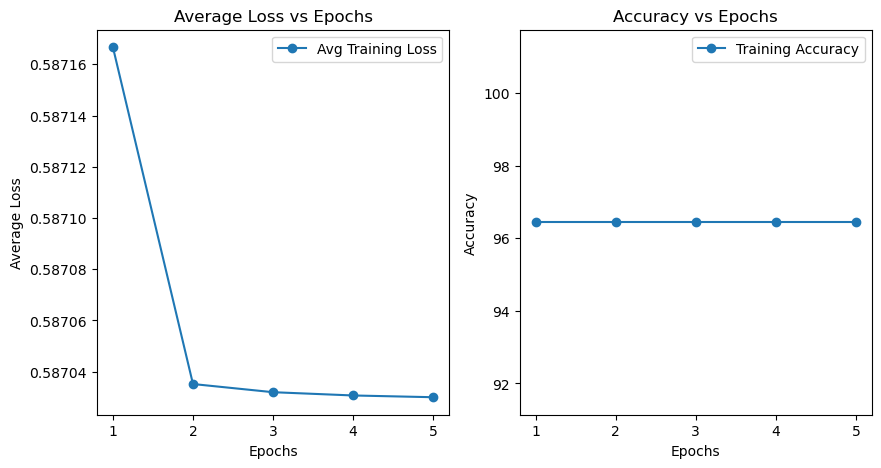

In [3]:
from mlp_helper import mlp_train

train_data = tensor_unified[:, torch.arange(tensor_unified.size(1)) != 0]
train_data = train_data.to(torch.float32)
hidden_dims = [10]
epochs = 5
batch_size = 10
learning_rate = 0.08
cuda = False
plots = True
test_data = test_data.to(torch.float32)

mlp_model, losses,plot = mlp_train(train_data,hidden_dims, epochs, batch_size, learning_rate, cuda, plots,test_data)

In [4]:
with torch.no_grad():
    test_preds = mlp_model(test_data)

In [5]:
test_preds.shape

torch.Size([102091, 3])

In [195]:
# Assuming your tensor is named 'tensor_data'
# Convert the tensor to a NumPy array

# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = predicted_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_40_step_length_mdw.csv')

In [199]:
df.start

index
0         0.000528
1         0.000073
2         0.000050
3         0.000112
4         0.000126
            ...   
102086    0.000000
102087    0.000000
102088    0.000000
102089    0.000000
102090    0.000000
Name: start, Length: 102091, dtype: float32

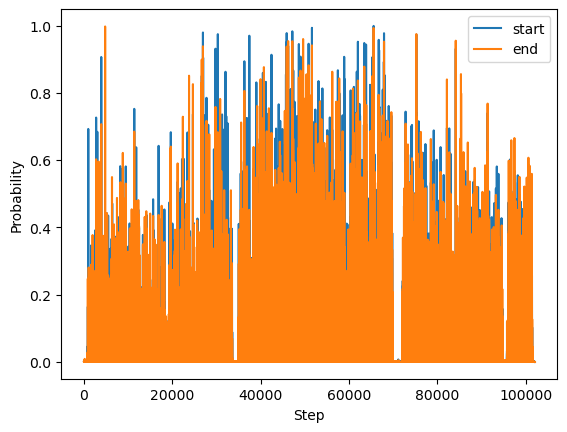

In [200]:
fig, ax = plt.subplots(1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(df.start, label='start')
ax.plot(df.end, label='end')

ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend()


plt.show()

### Test preprocessing


In [28]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    dataframe = pd.read_csv(file_path)

    # Convert DataFrame to a tensor
    tensor = torch.tensor(dataframe.values)

    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):#, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                # print(files)
                name_variableR = i+'_'+j+'_'+label[index_k]
                # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
                    # print(f'label df:\n{label_df}')
                    # print(f'index_start:\n{index_start}')
                    # print(f'index_end:\n{index_end}')
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # pd.set_option('display.max_rows', None)
            # print(label_df)
            # print(main_df.iloc[1067:1228])
            # pd.set_option('display.max_rows', 10)
            # print(f'main df:\n{main_df}')

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,2,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            
    
            steps1=[]
            steps2=[]
            step = False
            for index, row in main_df.iterrows():
                if row['label'] == 1:
                    step = not step  # Toggle the value of 'step'
                if step:
                    steps1.append(index)
                else:
                    steps2.append(index)
            
            main_df['label'] = main_df.apply(lambda row: 1 if row.name in steps1 else 0, axis=1)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])

# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]

In [8]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,0]
labelssteps = tensor_unified[:,7]
# print(labelssteps)
labels = labels.long()
labelssteps = labelssteps.long()

training_data = [data,labelssteps]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


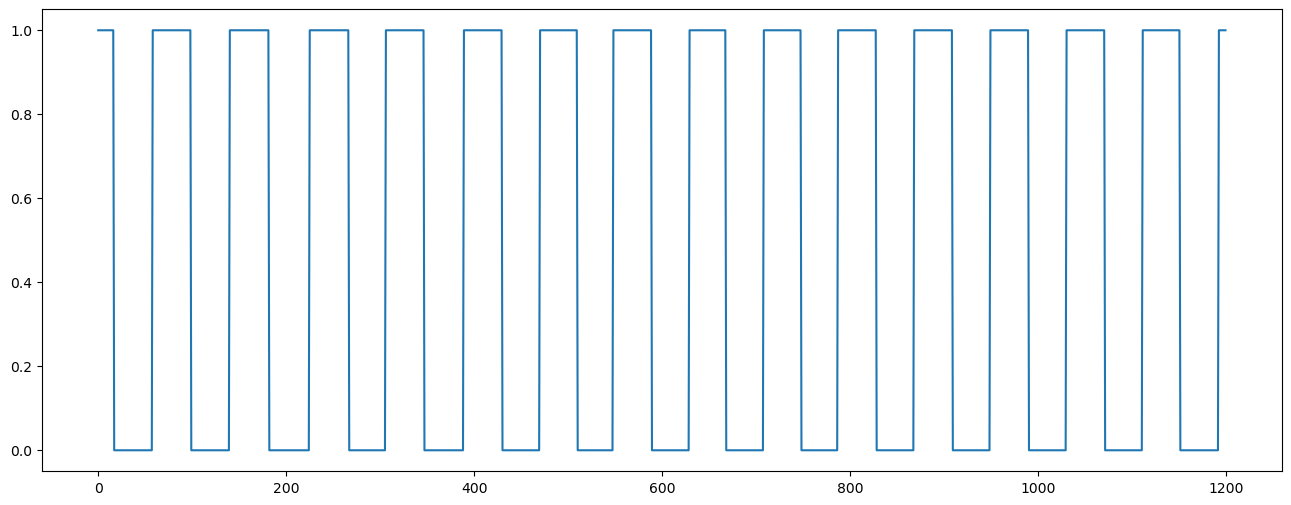

Average period: 57.796916691372665
Average up time: 58.216488730723604
Average down time: 57.41162514827995


In [129]:
# Convert the PyTorch tensor to a NumPy array
numpy_array = labelssteps.numpy()
# Reshape the NumPy array to a single column
reshaped_array = numpy_array.reshape(-1, 1)
# Create a pandas DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array, columns=['Column_Name'])
labels_df_g = df.loc[0:2000]

labelssteps2 = labelssteps[2000:3200]
fig, (ax) = plt.subplots(1,figsize = (16,6))
# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(labelssteps2, label='Activity')
plt.show()

signal_values = labelssteps[5000:200000]

# Example signal values
# signal_values = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1]

# Identify transitions and calculate time differences
transitions = [i for i in range(1, len(signal_values)) if signal_values[i] != signal_values[i-1]]
time_diffs = [transitions[i] - transitions[i-1] for i in range(1, len(transitions))]

# Calculate average period
average_period = sum(time_diffs) / len(time_diffs)

# Calculate average up and down time
average_up_time = sum(time_diffs[::2]) / (len(time_diffs) // 2)
average_down_time = sum(time_diffs[1::2]) / (len(time_diffs) // 2)

print("Average period:", average_period)
print("Average up time:", average_up_time)
print("Average down time:", average_down_time)

In [23]:
# Example signal data
signal_data = [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1]

# Design the low-pass filter
cutoff_freq = 2  # Specify the cutoff frequency in Hz
sampling_freq = 10  # Specify the sampling frequency in Hz
nyquist_freq = 0.5 * sampling_freq
normalized_cutoff_freq = cutoff_freq / nyquist_freq
b, a = signal.butter(2, normalized_cutoff_freq, btype='low')

# Apply the filter to the signal
filtered_signal = signal.lfilter(b, a, signal_data)

print(filtered_signal)

[0.20657208 0.90262238 1.94567029 3.0210958  4.04053814 5.03295311
 5.61319895 5.22014106 4.13498582 2.98466983 1.94579869]


In [24]:
bs = 64
ts = 20




# Select specific columns for norm calculation
selected_columns = data[:, [1,2,3]]  # Example: columns 1 and 2

# Compute and store the norm in the selected columns
torch.norm_(selected_columns, dim=1)

scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labelssteps]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=ts)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [125]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 0.5  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns

print(data_norm_new)

scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()


tensor([[ 0.0000e+00,  3.3836e-09,  2.4979e-08,  ..., -4.1387e-08,
         -1.5862e-07, -2.3171e-07],
        [ 0.0000e+00,  3.4084e-09,  2.5011e-08,  ..., -4.4423e-08,
         -1.6316e-07, -2.3718e-07],
        [ 0.0000e+00,  3.4025e-09,  2.4838e-08,  ..., -5.0600e-08,
         -1.7204e-07, -2.4773e-07],
        ...,
        [ 0.0000e+00,  8.7339e-09,  6.5950e-08,  ...,  7.1955e-07,
          9.2062e-07,  1.0746e-06],
        [ 0.0000e+00,  8.9649e-09,  6.7225e-08,  ...,  7.2460e-07,
          9.2476e-07,  1.0773e-06],
        [ 0.0000e+00,  9.0616e-09,  6.7771e-08,  ...,  7.2449e-07,
          9.2245e-07,  1.0726e-06]])


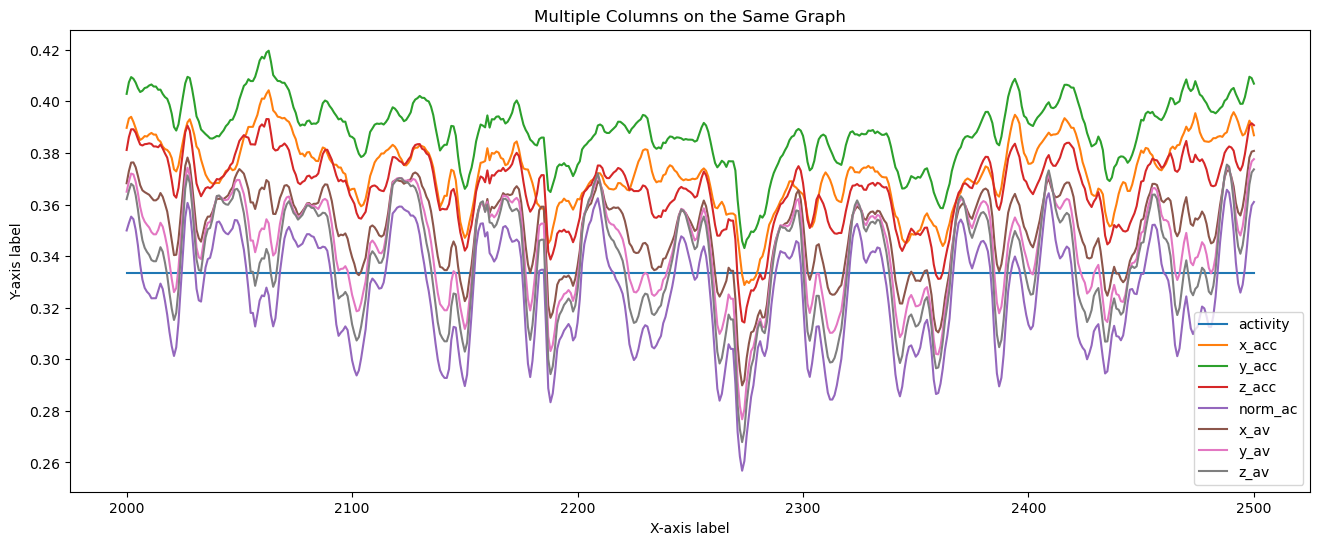

In [127]:
labels_df = pd.DataFrame(training_data[1].numpy())
data_df = pd.DataFrame(data_scaled2.numpy())
# print(data_df)
size_w = 500
a_begin = 2000
aend = a_begin+size_w
data_df_g = data_df.loc[a_begin:aend]
labels_df_g = labels_df.loc[a_begin:aend]

# Assuming you have a DataFrame named 'df' and a list of new column names
new_column_names = ['activity','x_acc', 'y_acc', 'z_acc', 'x_av', 'y_av', 'z_av','norm_ac']
new_column_names_labels = ['steps']

# Assign the new column names to the DataFrame
data_df_g.columns = new_column_names
labels_df_g.columns = new_column_names_labels

fig, (ax) = plt.subplots(1,figsize = (16,6))

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(data_df_g['activity'], label='activity')
ax.plot(data_df_g['x_acc'], label='x_acc')
ax.plot(data_df_g['y_acc'], label='y_acc')
ax.plot(data_df_g['z_acc'], label='z_acc')
ax.plot(data_df_g['norm_ac'], label='norm_ac')
ax.plot(data_df_g['x_av'], label='x_av')
ax.plot(data_df_g['y_av'], label='y_av')
ax.plot(data_df_g['z_av'], label='z_av')

ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Multiple Columns on the Same Graph')
ax.legend()

# ax1.plot(labels_df_g['steps'], label='steps')

plt.show()


In [11]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

#### No mode

In [22]:
print('Preparing datasets')

dataloader = DataLoader(train_data_scaled_step, batch_size=bs, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=bs, shuffle=False,drop_last= True)

print('Setting parameters of model')

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 2

lr = 0.01
n_epochs = 15
best_acc = 0
patience, trials = 5, 0
print_n_batch = 5
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)

print(f'input_dim {input_dim} hidden_dim {hidden_dim} layer_dim {layer_dim} output_dim {output_dim}')
print(f'lr {lr} epochs {n_epochs} patience epochs {patience}')

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    print(f'Training Epoch {epoch}')
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm_sqw_no_mode.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.3%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Setting parameters of model
input_dim 7 hidden_dim 120 layer_dim 1 output_dim 2
lr 0.01 epochs 15 patience epochs 5
Start model training
Training Epoch 1
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Accuracy epoch 1 60.40%
Epoch 1 best model saved with accuracy: 60.404%
Training Epoch 2
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Accuracy epoch 2 62.98%
Epoch 2 best model saved with accuracy: 62.982%
Training Epoch 3
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Accuracy epoch 3 62.57%
Training Epoch 4
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Accuracy epoch 4 64.86%
Epoch 4 best model saved with accuracy: 64.858%
Training Epoch 5
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Accuracy epoch 5 52.40%
Epoch:   5. Loss: 0.7020. Acc.

#### With mode

In [29]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [32]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns


scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

training_data_scaled = [data_scaled2,labels]

time_step = 25

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled2.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDatasetLSTM(training_data_scaled,time_steps=time_step)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [47]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0,int_dim = 64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [49]:
print('Preparing datasets')
bs = 128
dataloader = DataLoader(train_data_scaled_step, batch_size=bs, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=bs, shuffle=False,drop_last= True)

print('Setting parameters of model')

input_dim = 8
hidden_dim = 120
layer_dim = 2
output_dim = 2

lr = 0.001
n_epochs = 25
best_acc = 0
patience, trials = 5, 0
print_n_batch = 5
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)


print(f'input_dim {input_dim} hidden_dim {hidden_dim} layer_dim {layer_dim} output_dim {output_dim}')
print(f'lr {lr} epochs {n_epochs} patience epochs {patience}')

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm=0.2,int_dim=64)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    print(f'Training Epoch {epoch}')
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm_sqw_w_mode.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.3%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Setting parameters of model
input_dim 8 hidden_dim 120 layer_dim 2 output_dim 2
lr 0.001 epochs 25 patience epochs 5
Start model training
Training Epoch 1
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   1. Loss: 0.6797. Acc.: 51.397%
Epoch 1 best model saved with accuracy: 51.397%
Training Epoch 2
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   2. Loss: 0.6704. Acc.: 51.268%
Training Epoch 3
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   3. Loss: 0.6771. Acc.: 53.695%
Epoch 3 best model saved with accuracy: 53.695%
Training Epoch 4
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   4. Loss: 0.6701. Acc.: 52.296%
Training Epoch 5
Percentage done: 25.0%
Percentage done: 50.0%
Percentage done: 75.0%
Percentage done: 100.0%
Epoch:   5. Loss: 0.6985. Acc.: 52.74

In [57]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

act size torch.Size([102091, 1]) test size torch.Size([102091, 6])
act size torch.Size([102091, 7])


In [58]:
data_norm = test_data_w_act.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]
# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)
# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)
# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2
# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()
# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)
# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)
# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)
# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns

test_data_scaled_steps = torch.tensor(scalerSteps.transform(data_norm_new))
test_data_scaled_steps = test_data_scaled_steps.float()
test_data_scaled_steps = torch.tensor(scalerSteps2.transform(test_data_scaled_steps))
test_data_scaled_steps = test_data_scaled_steps.float()

In [59]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0,int_dim = 64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [78]:
path_steps_model = 'best_steps_lstm_sqw_w_mode.pth'

bs = 128

print('Setting parameters of model')

input_dim = 8
hidden_dim = 120
layer_dim = 2
output_dim = 2

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=25)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0),dtype=torch.long)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        predictions = pred_probab.argmax(1)
        predicted_labels = torch.cat([predicted_labels,predictions])
        

Setting parameters of model


In [79]:
zeros_pad_init = torch.zeros(20)
zeros_pad_end = torch.zeros(4)
pstart = torch.cat([zeros_pad_init,predicted_labels.clone(),zeros_pad_end])
pend = torch.cat([zeros_pad_init,predicted_labels.clone(),zeros_pad_end])

pstart = torch.roll(pstart,shifts=-20,dims=0)
pend = torch.roll(pend,shifts=-19,dims=0)

# Calculate differences between consecutive elements
differences = torch.diff(pstart)
# Set transitions as 1 and other values as 0
binary_wave = torch.zeros_like(pstart)
binary_wave[:-1][differences != 0] = 1

# Calculate differences between consecutive elements
differences2 = torch.diff(pend)
# Set transitions as 1 and other values as 0
binary_wave2 = torch.zeros_like(pend)
binary_wave2[:-1][differences2 != 0] = 1

predicted_labels2 = [binary_wave.numpy(),binary_wave2.numpy()]
array_data = np.array(predicted_labels2)
array_data = array_data.T


# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_activity_sqw_mode.csv')



In [80]:
array_data.shape

(102091, 2)

In [ ]:
starts_results.pop()
ends_results.pop()
predicted_labels = [starts_results,ends_results]
array_data = np.array(predicted_labels)
array_data = array_data.T

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_avg_results_better_data.csv')

In [ ]:
# Example usage
batch_size = 64

dataloader = DataLoader(train_data_scaled, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled, batch_size=batch_size, shuffle=False,drop_last= True)



print('Preparing datasets')

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

lr = 0.01
n_epochs = 15
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')
# print('dataloader', dataloader)
# sequence_length = 10

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch_v.size(0)
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


#### LSTM with 2 layers, dropout.

In [69]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [70]:
test_data = torch.tensor(dataframe.values)

test_data_sel_columns = test_data[:,0:3]
test_norms = torch.norm(test_data_sel_columns, dim=1).unsqueeze(1)
# Concatenate the original tensor and norms along the second dimension
test_data_norm_new = torch.cat((test_data, test_norms), dim=1)
# Select the columns to apply the filters
test_selected_columns = test_data_norm_new[:, 0:]  # Example: columns 1 and 2
# Convert the selected columns to a NumPy array
test_numpy_array = test_selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
test_filtered_columns = signal.lfilter(b, a, test_numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
test_filtered_columns = signal.lfilter(b, a, test_filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
test_filtered_columns = torch.from_numpy(test_filtered_columns)

# Replace the selected columns with the filtered values
test_data_norm_new[:, 0:] = test_filtered_columns
test_data_norm_new = test_data_norm_new[:,[0,1,2,6]]

data_norm = data.clone()
selected_columns = data_norm[:, 1:4]
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns
data_norm_new = data_norm_new[:,[1,2,3,7]]

# Fitting Scaler
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

# Scaling Test Data Set
test_data_scaled_act = torch.tensor(scalerSteps.transform(test_data_norm_new))
test_data_scaled_act = test_data_scaled_act.float()
test_data_scaled_act = torch.tensor(scalerSteps2.transform(test_data_scaled_act))
test_data_scaled_act = test_data_scaled_act.float()


In [71]:
class LSTMClassifier_steps_dropout(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2,int_dim = 128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [72]:
batch_size = 128
ts = 25

path_steps_model = 'lstm_mid_value_recall.pth'
print('Preparing datasets')

input_dim = 4
hidden_dim = 120
layer_dim = 2
output_dim = 3

print('Setting parameters of model')

model = LSTMClassifier_steps_dropout(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))

dataset = MyDatasetLSTM_testing(test_data_scaled_act,time_steps=ts)

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0),dtype=torch.long)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        # predictions = pred_probab.argmax(1)
        predicted_labels = torch.cat([predicted_labels,pred_probab])

Preparing datasets
Setting parameters of model


In [80]:
predicted_labels[:,[0]]

tensor([[0.0287, 0.0286],
        [0.0290, 0.0288],
        [0.0293, 0.0291],
        ...,
        [0.0386, 0.0389],
        [0.0389, 0.0392],
        [0.0391, 0.0395]])

In [88]:
predictions = predicted_labels[:,[1,2]]
min_prob = torch.min(predictions)
tensor_filler = torch.full((12,2), min_prob)
predictions2 = torch.cat([tensor_filler,predictions,tensor_filler],dim=0)
# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = predictions2.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_2lstms_just_acc_better_recall_preprocessedoutput.csv')

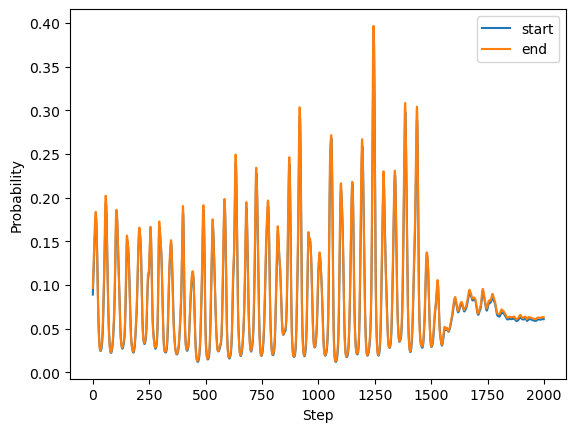

In [96]:
fig, ax = plt.subplots(1)


scalerStepsPostProcessing = preprocessing.MinMaxScaler()
array_data_scaled = torch.tensor(scalerStepsPostProcessing.fit_transform(array_data))
array_data_scaled = array_data_scaled.float()


# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(array_data_scaled[:,0].numpy()[100000:102000], label='start')
ax.plot(array_data_scaled[:,1].numpy()[100000:102000], label='end')

ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend()

plt.show()

array_data = array_data_scaled.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_2lstms_just_acc_better_recall_preprocessedoutput.csv')

#### Preprocessing Increasing Step range for better detection and using mode

In [64]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    dataframe = pd.read_csv(file_path)

    # Convert DataFrame to a tensor
    tensor = torch.tensor(dataframe.values)

    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):#, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                name_variableR = i+'_'+j+'_'+label[index_k]
                # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # pd.set_option('display.max_rows', None)
            # print(label_df)
            # print(main_df.iloc[1067:1228])
            # pd.set_option('display.max_rows', 10)
            # print(f'main df:\n{main_df}')

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,2,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            # print(main_df)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])
    
# Custom dataset class
class MyDataset2_mid_mod(Dataset):
    def __init__(self, sequence,labels,time_steps,mode_size):
        self.sequence = sequence
        self.labels = labels
        self.time_steps = time_steps
        self.mode_size = int(mode_size/2)
        self.mid_point = int(self.time_steps/2)
        self.mid_plus = self.mid_point+self.mode_size
        self.mid_minus = self.mid_point-self.mode_size

    def __len__(self):
        return len(self.labels) - self.time_steps + 1

    def __getitem__(self, idx):
        sequence = self.sequence[idx:idx+self.time_steps]
        label = torch.mode(self.labels[idx+self.mid_minus:idx+self.mid_plus])[0]
        return sequence, label

# Custom dataset class
class MyDataset2(Dataset):
    def __init__(self, sequence,labels, time_steps):
        self.sequence = sequence
        self.labels = labels
        self.time_steps = time_steps

    def __len__(self):
        return len(self.labels) - self.time_steps + 1

    def __getitem__(self, idx):
        sequence = self.sequence[idx:idx+self.time_steps]
        label = self.labels[idx+int((self.time_steps)/2)]
        return sequence, label
    
# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]


In [62]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


numpy_array = labels.numpy()

# 1. method: just increasing the ranges of labels 1. Shape stays the same.
#ones_idx = np.array(numpy_array.nonzero()[0]) # This returns the indeces of every label 1, since there are only label 0 and label 1
ones_idx = np.array(np.where(numpy_array == 1))
new_ones_idx = []
for item in list(ones_idx):
  # Increase the range: 4 behind and 4 in front + 0 -> range in total = 9
  for i in range(0,4): 
    new_ones_idx.append(item + i)
new_ones_idx = np.array(new_ones_idx)

twos_idx = np.array(np.where(numpy_array == 2))
new_twos_idx = []
for item in list(twos_idx):
  # Increase the range: 4 behind and 4 in front + 0 -> range in total = 9
  for i in range(-3,0): 
    new_twos_idx.append(item + i)
new_twos_idx = np.array(new_twos_idx)

numpy_array[new_ones_idx] = 1
numpy_array[new_twos_idx] = 2

labels = torch.tensor(numpy_array)
labels = labels.long()



[0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1 0 0 0]


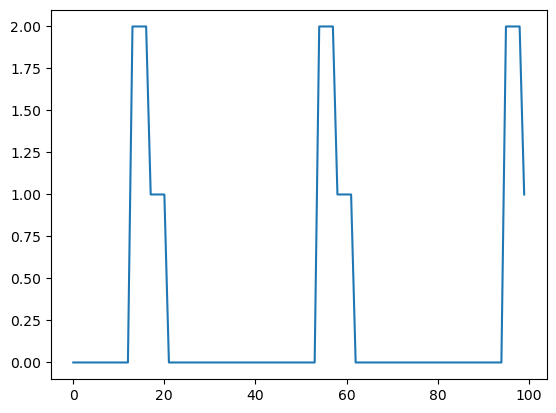

In [63]:
plt.plot(labels.numpy()[2000:2100])
print(labels.numpy()[2000:2024])
plt.show()

In [65]:
data_norm = data.clone()
# Select columns 1, 2, and 3 for norm calculation
selected_columns = data_norm[:, 1:4]

# Compute the norm for the selected columns
norms = torch.norm(selected_columns, dim=1).unsqueeze(1)

# Concatenate the original tensor and norms along the second dimension
data_norm_new = torch.cat((data_norm, norms), dim=1)

# Select the columns to apply the filters
selected_columns = data_norm_new[:, 1:]  # Example: columns 1 and 2

# Convert the selected columns to a NumPy array
numpy_array = selected_columns.numpy()

# Apply the low-frequency filter
low_cutoff = 3  # Specify the low-frequency cutoff
b, a = signal.butter(3, low_cutoff, fs=1000, output='ba')
filtered_columns = signal.lfilter(b, a, numpy_array, axis=1)

# Apply the high-frequency filter
high_cutoff = 100 # Specify the high-frequency cutoff
b, a = signal.butter(2, high_cutoff, fs=1000, btype='highpass', output='ba')
filtered_columns = signal.lfilter(b, a, filtered_columns, axis=1)

# Convert the filtered columns back to a PyTorch tensor
filtered_columns = torch.from_numpy(filtered_columns)

# Replace the selected columns with the filtered values
data_norm_new[:, 1:] = filtered_columns
data_norm_new = data_norm_new[:,[1,2,3,7]]


scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data_norm_new))
data_scaled = data_scaled.float()
scalerSteps2 = preprocessing.MinMaxScaler()
data_scaled2 = torch.tensor(scalerSteps2.fit_transform(data_scaled))
data_scaled2 = data_scaled2.float()

training_data_scaled = [data_scaled2,labels]


feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled2.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset2(data_scaled2,labels,time_steps=25)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [67]:
class LSTMClassifier_steps_dropout(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2,int_dim = 128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)
        # self.batch_size = None
        # self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [68]:
batch_size = 128

dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 4
hidden_dim = 120
layer_dim = 2
output_dim = 3

lr = 0.001
n_epochs = 10
best_acc = 0
best_rec = 0
best_f1 = 0
patience, trials = 10, 0

print_n_batch = 3
len_DL = len(dataloader)+1
p_at = np.linspace(1, len_DL, num=print_n_batch,dtype=int)

model = LSTMClassifier_steps_dropout(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay=0.001)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    k = 1
    for i, (x_batch, y_batch) in enumerate(dataloader):
        k+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        # print(f'y_batch {y_batch.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        if k in p_at:
            print(f'Percentage done: {round(100*k/len_DL,0)}%')

    model.eval()
    correct, total = 0, 0
    prec,rec = [],[]
    with torch.no_grad():
        for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
            out = model(x_batch_v)
            probs = F.log_softmax(out, dim=1)
            preds = probs.argmax(dim=1)

            # Convert tensors to NumPy arrays
            y_true = y_batch_v.numpy()
            y_pred = preds.numpy()

            # Calculate precision and recall for each class
            precision = precision_score(y_true, y_pred, average=None,zero_division=1)
            recall = recall_score(y_true, y_pred, average=None,zero_division=1)

            # Calculate average precision and recall
            avg_precision = np.mean(precision)
            avg_recall = np.mean(recall)
            prec.append(avg_precision)
            rec.append(avg_recall)

            total += (y_batch_v.size(0))
            correct += (preds == y_batch_v).sum().item()


    avg_rec = sum(rec) / len(rec)
    avg_prec = sum(prec) / len(prec)
    f1_avg = 2*avg_prec*avg_rec/(avg_prec+avg_rec)
    # print(f'recall {avg_rec} precision {avg_prec}')
    acc = correct / total
    # print(f'Accuracy epoch {epoch} {acc:2.3%}')
    condition1 = avg_rec > best_rec
    condition2 = acc > best_acc
    condition3 = f1_avg > best_f1


    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.3%} Recall: {avg_rec:2.3%} Prec.: {avg_precision:2.3%} F-1: {f1_avg:2.3%}')
    
    if condition1:
        trials = 0
        best_rec = avg_rec
        torch.save(model.state_dict(), 'lstm_mid_value_recall.pth')
        print(f'Epoch {epoch} best model saved with recall: {best_rec:2.3%}')

    if condition2:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'lstm_mid_value_acc.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.3%}')

    if condition3:
        trials = 0
        best_f1 = f1_avg
        torch.save(model.state_dict(), 'lstm_mid_value_f1.pth')
        print(f'Epoch {epoch} best model saved with F1: {best_f1:2.3%}')

    if not condition1 and not condition2 and not condition3:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   1. Loss: 0.3863. Acc.: 85.590% Recall: 34.607% Prec.: 61.905% F-1: 47.567%
Epoch 1 best model saved with recall: 34.607%
Epoch 1 best model saved with accuracy: 85.590%
Epoch 1 best model saved with F1: 47.567%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   2. Loss: 0.6983. Acc.: 85.579% Recall: 35.185% Prec.: 61.905% F-1: 47.010%
Epoch 2 best model saved with recall: 35.185%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   3. Loss: 0.4660. Acc.: 85.620% Recall: 35.299% Prec.: 61.905% F-1: 47.039%
Epoch 3 best model saved with recall: 35.299%
Epoch 3 best model saved with accuracy: 85.620%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   4. Loss: 0.4577. Acc.: 85.626% Recall: 35.448% Prec.: 61.905% F-1: 46.906%
Epoch 4 best model saved with recall: 35.448%
Epoch 4 best model saved with accuracy: 85.626%
Percentage done: 50.0%
Percentage done: 100.0%
Epoch:   5. Loss: 0

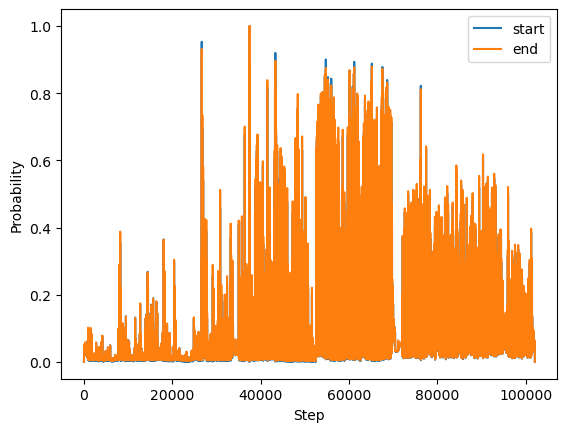

In [107]:
file = 'data_2lstms_just_acc_better_recall_preprocessedoutput.csv'
dataframe = pd.read_csv(file)
array = dataframe.to_numpy()

fig, ax = plt.subplots(1)
component1 = array[:,1]
component2 = array[:,2]

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(component1[:], label='start')
ax.plot(component2[:], label='end')

ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend()

plt.show()


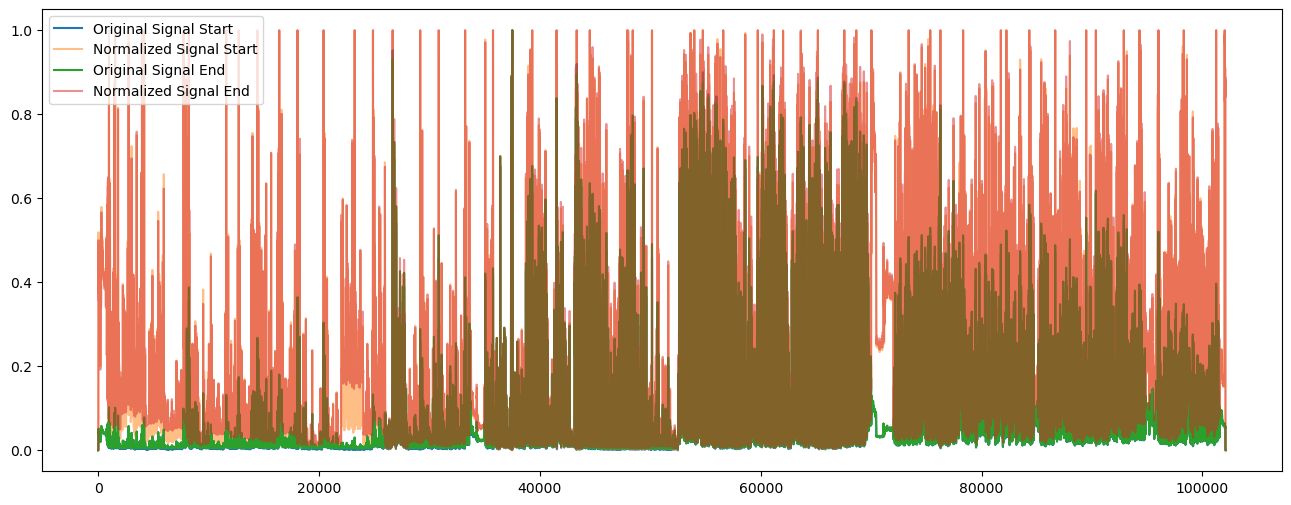

In [138]:
def normalize_signal(signal):
    local_maxima = np.r_[True, signal[1:] > signal[:-1]] & np.r_[signal[:-1] > signal[1:], True]
    max_amplitude = np.max(signal[local_maxima])
    normalized_signal = signal / max_amplitude
    return normalized_signal


original_signal = component1
original_signal2 = component2
new_signal_clean = original_signal.copy()
new_signal_clean2 = original_signal2.copy()
k = 2000
for i in range(0,original_signal.shape[0],k):
    new_signal = normalize_signal(original_signal[i:i+k])
    new_signal_clean[i:i+k] = new_signal
    new_signal2 = normalize_signal(original_signal2[i:i+k])
    new_signal_clean2[i:i+k] = new_signal2


# Example usage
# Plotting the original and normalized signals

plt.figure(figsize=(16, 6)) 
plt.plot(original_signal[:], label='Original Signal Start')
plt.plot(new_signal_clean[:], label='Normalized Signal Start',alpha = 0.5)
plt.plot(original_signal2[:], label='Original Signal End')
plt.plot(new_signal_clean2[:], label='Normalized Signal End',alpha = 0.5)
plt.legend()
plt.show()

In [142]:
array_data_post = np.vstack([new_signal_clean,new_signal_clean2]).T

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data_post, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_2lstms_just_acc_better_recall_preprocessedoutput_postprocess.csv')

In [112]:
original_signal.shape

(10000,)

In [103]:
probs = array[10000:20000,[1,2]]

component1 = array[:,1]
# probs2 = 

TypeError: 'numpy.bool_' object is not iterable